In [ ]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from scipy.signal import butter, lfilter
import librosa, librosa.display
from scipy.signal import hilbert, chirp
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import glob
from brian2 import *
from brian2hears import *
%matplotlib inline


def bandpower(data, sf, band, window_sec=None, relative=False):
    from scipy.signal import welch
    import scipy
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = scipy.signal.welch(data, sf,window = 'hamming',nfft = 512 ,scaling = 'density',average = 'mean')
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)  # assignment operator shorthand for / and =
        
    return freqs, psd ,bp
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butt_low(lowcut, fs, order=2):
    nyq = 0.5 * sr
    low = lowcut / nyq
    b, a = butter(order, low, btype='low')
    return b, a



In [2]:
file = 'audio/demo/kr.wav'  ## demo _ jp.wav

temp,fs = librosa.load(file)
print(fs)
sound= loadsound(file)
#x, index = librosa.effects.trim(sound,top_db= 20)
cf = erbspace(125*Hz,3.5*kHz, 32)
b1 = 1.019
gammatone = Gammatone(sound, cf, b=b1)
gt_mon = gammatone.process()


env = []
for i in range(len(gt_mon[1,:])):
    y = gt_mon[:,i]
    analytic_signal = hilbert(y)
    amplitude_envelope = np.abs(analytic_signal)
    env.append(amplitude_envelope)
    
    
modulation_filter = [2,4,8,16,32,64,128,256,512];       
lowcut = modulation_filter[:-1]
highcut = modulation_filter[1:]
modu = []
final = []
for j in range(len(env)):  
    modu = []
    for i in range(len(lowcut)):
        y= butter_bandpass_filter(env[j], lowcut[i], highcut[i], fs , order=2)
        #print('band pass frequency range is {} - {}'.format(lowcut[i], highcut[i]))
        modu.append(y)
    final = final + modu
len(final)

22050


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Build Tools for Visual Studio": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]


256

In [3]:
#x, sr = librosa.load('audio/demo/ru.wav')  ## my  better  vn better
#使用 ipython 播放音频；
#ipd.Audio(x, rate=sr)

In [4]:
## 原始 wav 文件；
#t_main = np.arange(len(temp)) / fs #  create a time _ vector
#librosa.display.waveplot(temp, sr=fs,,alpha=0.6)
#s = np.asfortranarray(gt_mon[:,31]) ##  是否符合 asfortranarry 的 check
#librosa.display.waveplot(s, sr = fs,alpha=0.4) ## 滤波过后的信号
#plt.plot(env[31],alpha=0.6) 获取包络；
#plt.plot(final[12],alpha = 0.8)

In [5]:
energy_all = []
for i in range(len(final)):
    x = final[i]
    hop_length = round(0.04*fs)   # 帧移 40ms  帧长 256ms; 
    frame_length = round(0.256*fs)
    rmse = librosa.feature.rms(final[i], frame_length=frame_length, hop_length=hop_length, center=True)
    rmse = rmse[0]
    energy = rmse
    energy = librosa.power_to_db(rmse)
    energy_all.append(energy)
E = np.array(energy_all)
#E_re = E.reshape(32,5,len(energy))
E_re = E.reshape(32,8,len(energy))
E_mean = np.mean(E_re,2)
print(E_re.shape)

(32, 8, 82)


Text(0, 0.5, 'DB')

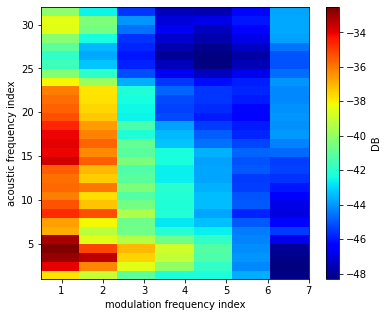

In [6]:
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

%matplotlib inline

s = E_mean
y = np.linspace(1,32,32)
#x = np.linspace(1,6,5)
x = np.linspace(0.5,7,8)
T, F = np.meshgrid(x,y) 

plt.figure(figsize=(6, 5))
plt.pcolormesh(T,F,s,cmap='jet')
plt.ylabel('acoustic frequency index')
plt.xlabel('modulation frequency index')
#plt.yticks(y,)
#plt.colorbar()
cbar=plt.colorbar()
cbar.ax.set_ylabel('DB')


In [7]:
cf[9:11]

array([0.47219097, 0.52752185]) * khertz

Text(0, 0.5, 'DB')

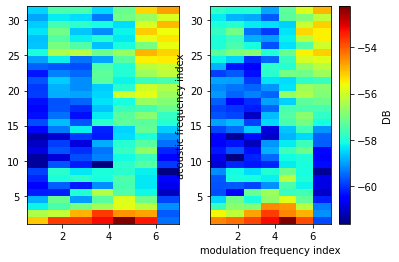

In [8]:
s1 = E_re[:,:,2]
s2 = E_re[:,:,3]

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

%matplotlib inline

#s = E_mean

plt.subplot(1,2,1)
y = np.linspace(1,32,32)
#x = np.linspace(1,6,5)
x = np.linspace(0.5,7,8)
T, F = np.meshgrid(x,y) 
plt.pcolormesh(T,F,s1,cmap='jet')

plt.subplot(1,2,2)
#plt.figure(figsize=(6, 5))
plt.pcolormesh(T,F,s2,cmap='jet')
plt.ylabel('acoustic frequency index')
plt.xlabel('modulation frequency index')
#plt.yticks(y,)


#plt.colorbar()
cbar=plt.colorbar()
cbar.ax.set_ylabel('DB')


Text(0.5, 0, 'modulation frequency index')

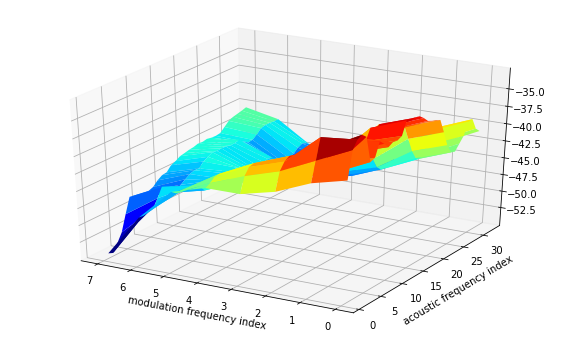

In [9]:
plt.rcParams['figure.figsize'] = (10, 6)
s = E_mean
from mpl_toolkits.mplot3d import Axes3D
y = np.linspace(1,32,32)
#x = np.linspace(5,1,5)
x = np.linspace(8,0,8)
T, F = np.meshgrid(x,y) 
fig = plt.figure()
ax = fig.gca(projection='3d') # 绘制成3D
ax.plot_surface(T,F,s,cmap='jet')
#ax.plot_surface(T[None,:], F[:,None], 10*np.log10(Zxx), cmap='plasma')
plt.xticks(x,[0,1,2,3,4,5,6,7])
#plt.yticks(x,ytk)
plt.ylabel('acoustic frequency index')
plt.xlabel('modulation frequency index')

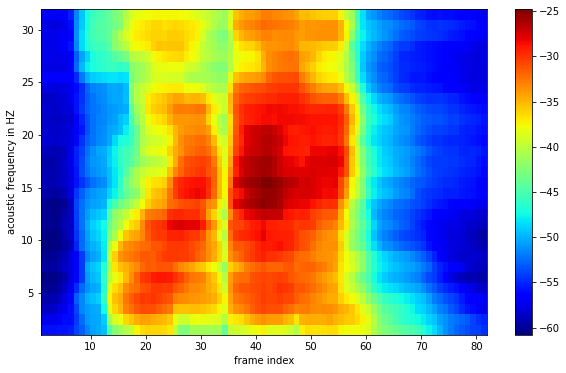

In [12]:
## ding nai 老师的建议 输出后平均 或者zscore;

import numpy as np
from scipy import stats

# a = np.array([0, 2, 2, 1, 0])
# print(stats.zscore(a))
length = len(E_mean[1,:])
## 类似语谱图
E_mean = np.mean(E_re,1)
s = E_mean
y = np.linspace(1,32,32)
#x = np.linspace(1,6,5) 
x = np.linspace(1,length,length)

T, F = np.meshgrid(x,y) 
plt.pcolormesh(T,F,s,cmap='jet')
plt.ylabel('acoustic frequency in HZ')
plt.xlabel('frame index')
plt.colorbar()

In [ ]:
E_re.shape